![MNIST](img/mnist.jpeg)

Ce notebook vous montre comment entraîner un **réseau de neurones simple (MLP : Multilayer Perceptron)** sur le jeu de données **MNIST**, 
qui contient des images de chiffres manuscrits (0 à 9).

🎯 **Objectifs pédagogiques** :
- Comprendre comment structurer un réseau de neurones
- Charger et préparer des données images simples
- Compiler, entraîner et évaluer un modèle Keras
- Observer les performances d’un réseau sur un cas réel

In [1]:
# Chargement des bibliothèques nécessaires à la démonstration

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# 1. Exploration des données
___

Avant de commencer l'entraînement du modèle, il est important d'**observer les données brutes**.  
Nous allons ici charger une **image PNG d’un chiffre manuscrit**, l’afficher et inspecter ses propriétés.

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253 159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 253 252 252  96 18

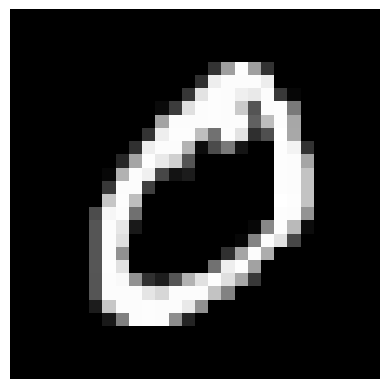

Shape (dimensions)    : (28, 28)
Type des valeurs      : uint8


In [2]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/mnist/train/0/train_image_1.png", cv2.IMREAD_GRAYSCALE)

# Observer l'image sous forme de matrice
print(img)

# Visualisation de l'image
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")


# 2. Préparation des données
___

Dans cette section, nous allons charger les images de chiffres manuscrits (dataset MNIST) depuis des dossiers. Chaque sous-dossier représente une classe (de 0 à 9), et contient les images correspondant à ce chiffre.

Le but est de :
- Lire chaque image en niveau de gris (valeurs entre 0 et 255)
- Associer chaque image à sa classe (le nom du dossier)
- Retourner deux tableaux : X pour les images, y pour les étiquettes


In [3]:
def get_train_test(base_path: str):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
    for label in sorted(os.listdir(base_path)):
        # on ignore les fichiers qui ne sont pas des dossiers de chiffres
        if not label.isdigit():
            continue
        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # image illisible, on passe
            X.append(img)           # on ajoute l'image à la liste
            y.append(int(label))    # on ajoute le label (ex: 0, 1, ..., 9)

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_test("data/mnist/train")
X_test, y_test = get_train_test("data/mnist/test")

Avant de lancer l’entraînement d’un réseau de neurones, il est important de visualiser quelques images pour vérifier que les données sont bien chargées, correctement orientées, et associées aux bonnes étiquettes.

Ci-dessous, nous affichons les 10 premières images du jeu d’entraînement X_train.


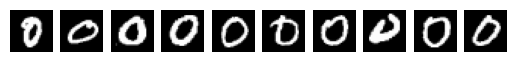

In [4]:
# Vérification des données préparées
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.show()

# 3. Preprocessing
___

Avant d’envoyer nos images dans un réseau de neurones, nous devons les prétraiter pour qu’elles soient dans un format compatible et optimisé pour l’apprentissage.

Cela inclut :
- La conversion des entiers (0–255) en nombres à virgule (float32)
- La normalisation des pixels entre 0.0 et 1.0
- Le flattening (mise à plat) des images 28x28 en vecteurs de 784 valeurs, car un MLP attend un vecteur d’entrée.

In [5]:
# Les images sont au format (28, 28). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

# Flatten : pour un MLP, chaque image 28x28 doit devenir un vecteur de 784 valeurs
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

# 4. Modélisation
___

Nous allons maintenant construire un réseau de neurones multicouche c'est à dire définir son architecture en cumulant les différentes couches :
- 1 couche d'entrée
- n couches cachées
- 1 couche de sortie

In [6]:
model = models.Sequential([
    layers.Input(shape=(784,)),            # Couche d'entrée : vecteur de 784 pixels
    layers.Dense(128, activation='relu'),  # 1ère couche cachée avec 128 neurones
    layers.Dense(64, activation='relu'),   # 2e couche cachée avec 64 neurones
    layers.Dense(10, activation='softmax') # Couche de sortie : 10 classes (0 à 9), avec softmax qui permet d’obtenir une probabilité pour chaque classe
])

Avant de pouvoir entraîner notre réseau de neurones, nous devons lui indiquer comment il doit apprendre. C’est le rôle de la méthode compile() dans Keras.

Concrètement, compiler un modèle, c’est définir trois éléments essentiels :

> L’**optimiseur**

L’optimiseur est l’algorithme qui ajuste les poids du réseau pour améliorer ses prédictions.
Il agit à chaque itération de l’entraînement en suivant le gradient de la fonction de perte.

Ici, on utilise adam : un optimiseur efficace et souvent utilisé par défaut.

> La **fonction de pert**e (loss function)

C’est une mesure de l’erreur entre les prédictions du modèle et les valeurs réelles.
Le modèle essaie de minimiser cette erreur.

Dans notre cas, on utilise **sparse_categorical_crossentropy** car :
- il s’agit d’un problème de classification multi-classes (10 chiffres, donc 10 classes)
- les étiquettes sont des entiers (ex : 0, 1, 2…)

> Les **métriques d’évaluation**

Les métriques servent à suivre les performances du modèle pendant l’entraînement.
La plus courante pour la classification est accuracy : le pourcentage de bonnes prédictions.

In [7]:
model.compile(
    optimizer='adam',                            # Méthode d’optimisation (descente de gradient)
    loss='sparse_categorical_crossentropy',      # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
    metrics=['accuracy']                         # On surveille l’exactitude pendant l'entraînement
)

In [8]:
# Résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Une fois le modèle défini et compilé, on passe à l’entraînement : c’est ici que le réseau apprend à prédire les bonnes classes à partir des images.

> **Que se passe-t-il pendant l’entraînement ?**

À chaque epoch :
- Le modèle passe sur toutes les images du jeu d’entraînement (X_train)
- Il fait des prédictions
- Compare les prédictions aux vraies étiquettes (y_train)
- Calcule la perte (l’erreur)
- Met à jour les poids internes pour réduire cette erreur (grâce à l’optimiseur)

Ce processus est répété plusieurs fois (une fois par epoch), ce qui permet au modèle d’améliorer progressivement ses performances.

> **Et le batch_size ?**

Le modèle ne traite pas toutes les images d’un coup (cela prendrait trop de mémoire).
Il les traite par lots (batches) de 64 images ici.

Après chaque batch, une mise à jour des poids est effectuée.

In [9]:
model.fit(
    X_train, y_train,        # Données d’entraînement
    epochs=10,               # Nombre de passages sur l’ensemble du dataset
    batch_size=64            # Nombre d’images traitées avant mise à jour des poids
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.8595 - loss: 0.4852
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.9637 - loss: 0.1178
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.9770 - loss: 0.0751
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.9831 - loss: 0.0542
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9860 - loss: 0.0436
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9888 - loss: 0.0353
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9918 - loss: 0.0257
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.9926 - loss: 0.0234
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - accuracy: 0.9940 - loss: 0.0183
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.9950 - loss: 0.0168


# 5. Évaluation du modèle

Une fois l’entraînement terminé, il est crucial de mesurer la performance du modèle sur des données qu’il n’a jamais vues : le jeu de test (X_test, y_test).

Cela permet de vérifier si le modèle a bien appris à généraliser, et non à simplement mémoriser les données d’entraînement.

In [10]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy sur le test : {acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9825 - loss: 0.0713
Accuracy sur le test : 97.85%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


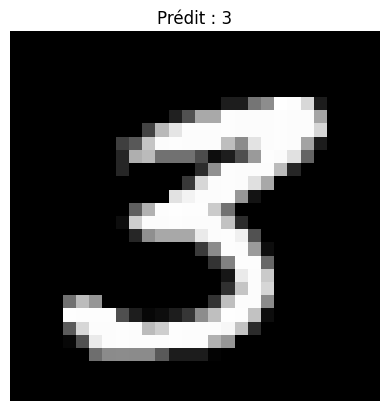

In [11]:
# Affichage d’un chiffre avec prédiction
img_to_predict = 3456
plt.imshow(X_test[img_to_predict].reshape(28, 28),cmap="grey")
plt.title(f"Prédit : {model.predict(X_test[[img_to_predict]]).argmax()}")
plt.axis('off')
plt.show()